In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import load_dataset
import matplotlib.pyplot as plt
from rdkit import Chem
import pubchempy as pcp

In [3]:
df_results = pd.read_csv("../Predictions/df_predictions_xgboost_emtree_filter_then_pred.csv")
# df_results = pd.read_csv("../Predictions/df_predictions_xgboost_emtree_filter_after_pred.csv")
# df_results = pd.read_csv("../Predictions/df_predictions_xgboost_emtree_no_filter.csv")

#drop collumns identified and value
# df_results = df_results.drop(columns=['Identified','Value'])

#reorder collumns in this order:  label, ambiguous, Predicted Label, Probability Estimate, qualifier, superLabel, concept, label_list, distance, super_list, superLabel_list, word_count and rename label to Term
df_results = df_results[['label','ambiguous','Predicted Label','Probability Estimate','qualifier','superLabel','concept','label_list','distance','super_list','superLabel_list','word_count']]
df_results = df_results.rename(columns={'label':'Term'})

In [4]:
# df_results.to_csv("../Predictions/df_predictions_xgboost_emtree_no_filter.tsv", sep='\t', index=False)

In [5]:
df_wrong = df_results[df_results['ambiguous'] != df_results['Predicted Label']]
df_cell_lines = pd.read_csv("../Data/RMC_cell_lines.csv")

In [6]:
df_wrong = df_wrong.copy()
df_wrong.sort_values(by=['Probability Estimate'], inplace=True)

In [7]:
# df_wrong

In [8]:
# Get the top 20 ambiguous labels that had the score closest to 0
ambiguous_wrong =df_wrong[df_wrong['ambiguous'] == True]
ambiguous_close_to_0 = df_wrong[df_wrong['ambiguous'] == True].nsmallest(40, 'Probability Estimate')

# Get the top 20 unambiguous labels that had score closer to 1
unambiguous_wrong =df_wrong[df_wrong['ambiguous'] == False]

unambiguous_close_to_1 = df_wrong[df_wrong['ambiguous'] == False].nlargest(40, 'Probability Estimate')

In [9]:
# ambiguous_wrong[ambiguous_wrong['superLabel'] == "procedures, parameters and devices"]

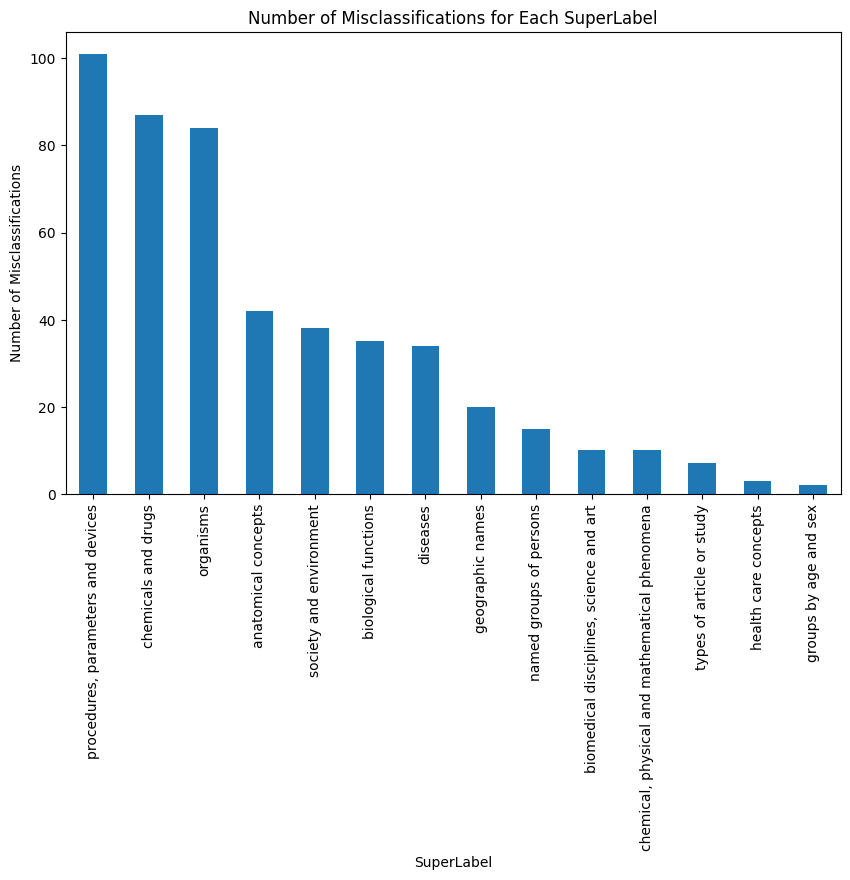

In [10]:
# Count the number of misclassifications for each 'superLabel'
misclassifications = df_wrong['superLabel'].value_counts()

# Sort the counts in descending order
misclassifications = misclassifications.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
misclassifications.plot(kind='bar')
plt.title('Number of Misclassifications for Each SuperLabel')
plt.xlabel('SuperLabel')
plt.ylabel('Number of Misclassifications')
plt.show()

In [11]:
len(df_wrong)

488

In [12]:
# Define the bin edges
bin_edges = np.linspace(0, 1, 11)  # creates an array [0.0, 0.1, 0.2, ..., 1.0]

# Create a new column 'Bin' in df_results that indicates which bin each probability estimate falls into
df_results['Bin'] = pd.cut(df_results['Probability Estimate'], bins=bin_edges)

# Add a 'Bin' column to df_wrong
df_wrong['Bin'] = pd.cut(df_wrong['Probability Estimate'], bins=bin_edges)

# # Get the instances where the model was wrong
# df_wrong = df_results[df_results['ambiguous'].astype(int) != df_results['Predicted Label']]

# Count the total number of instances and the number of wrong predictions in each bin
total_counts = df_results['Bin'].value_counts().sort_index()
wrong_counts = df_wrong['Bin'].value_counts().sort_index()

# Calculate the percentage of wrong predictions in each bin
wrong_percentages = wrong_counts / total_counts * 100

# Print the results
print("Percentage of wrong predictions in each bin:")
print(wrong_percentages)

Percentage of wrong predictions in each bin:
Bin
(0.0, 0.1]     0.610406
(0.1, 0.2]     7.161804
(0.2, 0.3]    10.303030
(0.3, 0.4]    11.111111
(0.4, 0.5]    11.827957
(0.5, 0.6]    77.941176
(0.6, 0.7]    73.333333
(0.7, 0.8]    68.852459
(0.8, 0.9]    57.692308
(0.9, 1.0]    32.706767
Name: count, dtype: float64


/scratch-local/dpapadopoulos/ipykernel_2806447/3407152124.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_superLabel_counts = df_wrong.groupby(['Bin', 'superLabel']).size().reset_index(name='Counts')


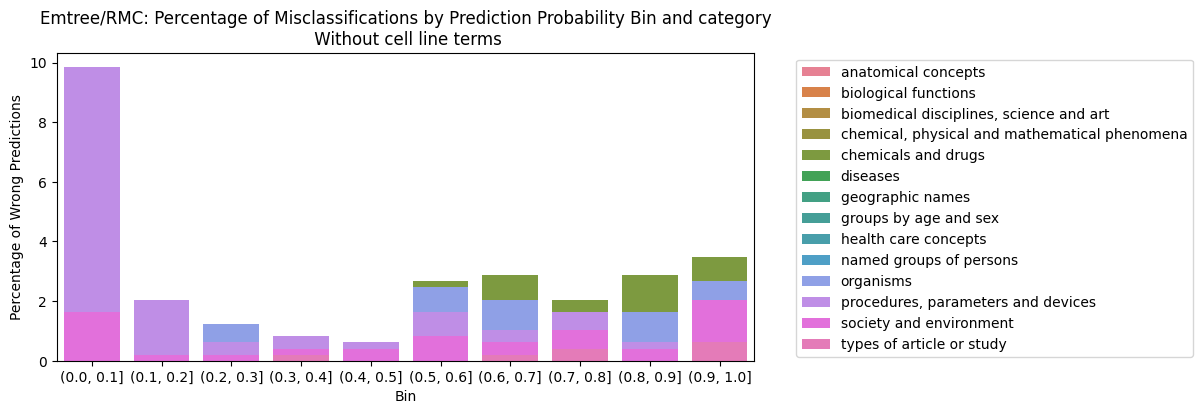

In [13]:
total_wrong = df_wrong.shape[0]

# Count the number of wrong predictions for each 'superLabel' within each bin
bin_superLabel_counts = df_wrong.groupby(['Bin', 'superLabel']).size().reset_index(name='Counts')
bin_superLabel_counts['Percentage'] = bin_superLabel_counts['Counts'] / total_wrong * 100

# Create a bar plot with one bar for each 'superLabel' within each bin
plt.figure(figsize=(9, 4))
sns.barplot(x='Bin', y='Percentage', hue='superLabel', data=bin_superLabel_counts, dodge=False)
# plt.suptitle('Without cell line terms')
plt.title('Emtree/RMC: Percentage of Misclassifications by Prediction Probability Bin and category\n Without cell line terms')
plt.xlabel('Bin')
plt.ylabel('Percentage of Wrong Predictions')

# Place the legend outside of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [14]:
bin_superLabel_counts.to_csv("test",index=None)

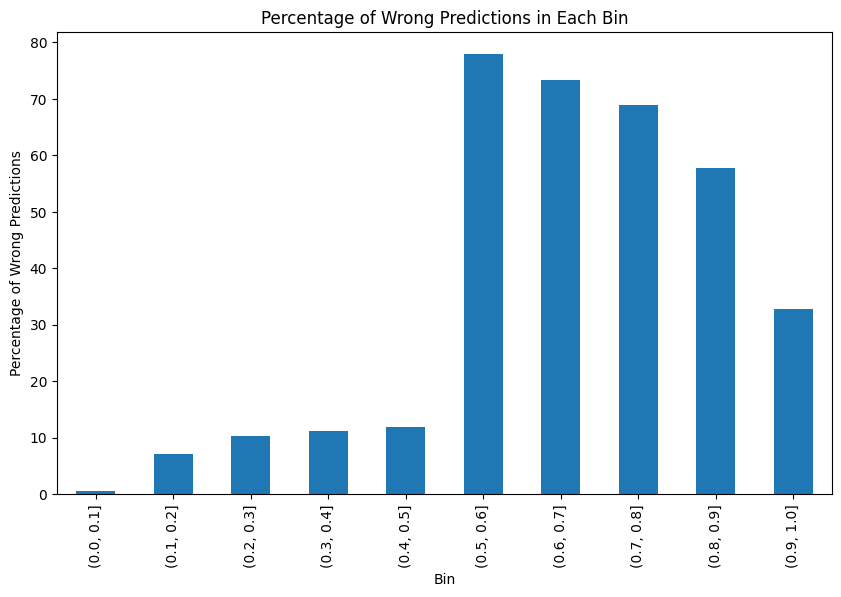

In [15]:
# Plot the percentage of wrong predictions in each bin
plt.figure(figsize=(10, 6))
wrong_percentages.plot(kind='bar')
plt.title('Percentage of Wrong Predictions in Each Bin')
plt.xlabel('Bin')
plt.ylabel('Percentage of Wrong Predictions')
plt.show()

In [16]:
# Count the total number of wrong predictions
total_wrong = len(df_wrong)

# Calculate the percentage of the total wrong predictions that fall into each bin
percentage_of_wrongs = wrong_counts / total_wrong * 100

# Print the results
print("Distribution of mistakes to bins:")
print(percentage_of_wrongs)


Distribution of mistakes to bins:
Bin
(0.0, 0.1]    30.532787
(0.1, 0.2]     5.532787
(0.2, 0.3]     3.483607
(0.3, 0.4]     2.663934
(0.4, 0.5]     2.254098
(0.5, 0.6]    10.860656
(0.6, 0.7]     9.016393
(0.7, 0.8]     8.606557
(0.8, 0.9]     9.221311
(0.9, 1.0]    17.827869
Name: count, dtype: float64


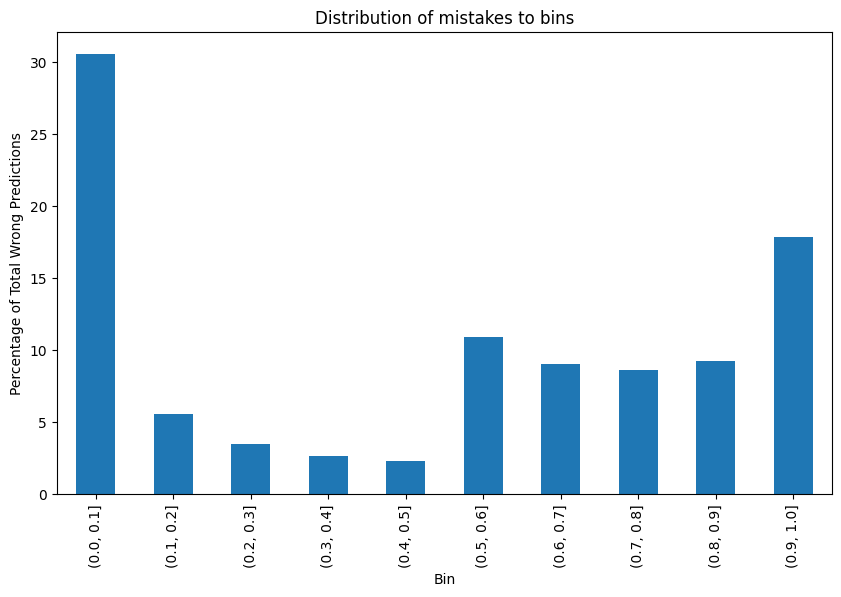

In [17]:
# Plot the percentage of total wrong predictions in each bin
plt.figure(figsize=(10, 6))
percentage_of_wrongs.plot(kind='bar')
plt.title('Distribution of mistakes to bins')
plt.xlabel('Bin')
plt.ylabel('Percentage of Total Wrong Predictions')
plt.show()


In [18]:
print("Total Counts in each Bin:")
print(total_counts)

print("\nWrong Counts in each Bin:")
print(wrong_counts)

# Set the maximum rows option to None to display all rows
pd.set_option('display.max_rows', None)

# Now print the DataFrame
print("\n'SuperLabel' Counts in each Bin:")
print(bin_superLabel_counts)

pd.reset_option('display.max_rows')

Total Counts in each Bin:
Bin
(0.0, 0.1]    24410
(0.1, 0.2]      377
(0.2, 0.3]      165
(0.3, 0.4]      117
(0.4, 0.5]       93
(0.5, 0.6]       68
(0.6, 0.7]       60
(0.7, 0.8]       61
(0.8, 0.9]       78
(0.9, 1.0]      266
Name: count, dtype: int64

Wrong Counts in each Bin:
Bin
(0.0, 0.1]    149
(0.1, 0.2]     27
(0.2, 0.3]     17
(0.3, 0.4]     13
(0.4, 0.5]     11
(0.5, 0.6]     53
(0.6, 0.7]     44
(0.7, 0.8]     42
(0.8, 0.9]     45
(0.9, 1.0]     87
Name: count, dtype: int64

'SuperLabel' Counts in each Bin:
            Bin                                     superLabel  Counts  \
0    (0.0, 0.1]                            anatomical concepts      13   
1    (0.0, 0.1]                           biological functions      14   
2    (0.0, 0.1]        biomedical disciplines, science and art       4   
3    (0.0, 0.1]  chemical, physical and mathematical phenomena       2   
4    (0.0, 0.1]                            chemicals and drugs      16   
5    (0.0, 0.1]              

In [19]:
# # Get the unique superLabels
# unique_superLabels = df_wrong['superLabel'].unique()

# # For each superLabel, plot a histogram of the wrong predictions
# for superLabel in unique_superLabels:
#     df_superLabel = df_wrong[df_wrong['superLabel'] == superLabel]
#     wrong_counts_superLabel = df_superLabel['Bin'].value_counts().sort_index()
#     wrong_percentages_superLabel = wrong_counts_superLabel / len(df_superLabel) * 100

#     plt.figure(figsize=(10, 6))
#     wrong_percentages_superLabel.plot(kind='bar')
#     plt.title(f'Percentage of Wrong Predictions in Each Bin for {superLabel}')
#     plt.xlabel('Bin')
#     plt.ylabel('Percentage of Wrong Predictions')
#     plt.show()


In [20]:
# Suppose 'df_cell_lines' is your DataFrame of cell-lines and 'concept' is the column with the cell-line names
cell_lines = df_cell_lines['concept'].tolist()

# Filter 'df_wrong' to only include the rows where the 'concept' is a cell-line
df_wrong_cell_lines = df_wrong[df_wrong['concept'].isin(cell_lines)]

# Print the number of misclassifications that are cell-lines
print(f"Number of misclassifications that are cell-lines: {len(df_wrong_cell_lines)}")


Number of misclassifications that are cell-lines: 0


In [23]:
results = pd.read_csv('/home/dpapadopoulos/dsls-papadopoulos-ambiguity-scoring-thesis/Results/pipeline_metrics_final_bert_emtree_20240611-061657(multiple undersampling ratios for graph).csv')
no_undersampling_results = pd.read_csv('/home/dpapadopoulos/dsls-papadopoulos-ambiguity-scoring-thesis/Results/pipeline_metrics_final_bert_emtree_20240612-213849.csv')


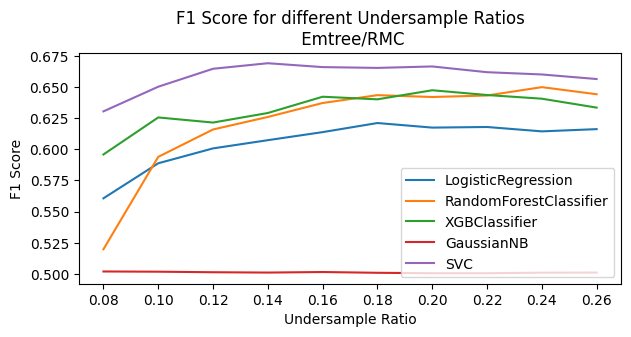

In [24]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(7,3))

# Loop over each method
for method in results['Method'].unique():
    # Filter the results for the current method
    method_results = results[results['Method'] == method]

    # Plot the F1 Score against the Undersample Ratio for the current method
    ax.plot(method_results['UnderSample Ratio'], method_results['F1 Score'], label=method)

# Set the title and labels
ax.set_title('F1 Score for different Undersample Ratios\n Emtree/RMC')
ax.set_xlabel('Undersample Ratio')
ax.set_ylabel('F1 Score')

# Set x-axis ticks to be exactly the undersample ratios used
ax.set_xticks(results['UnderSample Ratio'].unique())

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [25]:
#create CI for pipeline
import pandas as pd  
import numpy as np  
from scipy import stats  

# Load the aggregated metrics from the CSV file  
aggregated_metrics_df = pd.read_csv('/home/dpapadopoulos/dsls-papadopoulos-ambiguity-scoring-thesis/Results/aggregated_pipeline_metrics_bert_emtree_20240621-140853.csv')  

# Select only the numeric columns for aggregation  
numeric_columns = ['Accuracy', 'Precision', 'Recall', 'ROC AUC', 'F1 Score']  

# Group by the classifier and calculate mean and standard deviation for each metric  
grouped_metrics = aggregated_metrics_df.groupby('Method')[numeric_columns].agg(['mean', 'std']).reset_index()  

# Define the confidence level  
confidence_level = 0.95  

# Calculate the confidence intervals  
for metric in numeric_columns:  
    mean_col = (metric, 'mean')  
    std_col = (metric, 'std')  
    n = len(aggregated_metrics_df['Seed'].unique())  # Number of runs  

    # Calculate the margin of error  
    margin_of_error = stats.t.ppf((1 + confidence_level) / 2., n - 1) * (grouped_metrics[std_col] / np.sqrt(n))  

    # Calculate the confidence intervals  
    grouped_metrics[(metric, 'CI Lower')] = grouped_metrics[mean_col] - margin_of_error  
    grouped_metrics[(metric, 'CI Upper')] = grouped_metrics[mean_col] + margin_of_error  

# Save the results to a CSV file  
grouped_metrics.to_csv('/home/dpapadopoulos/dsls-papadopoulos-ambiguity-scoring-thesis/Results/confidence_intervals_bert_emtree_20240621-140853.csv', index=False)

In [26]:
grouped_metrics

Method  Accuracy           Precision              Recall            \
                       mean       std      mean       std      mean       std   
0  Majority Class  0.926384  0.000763  0.000000  0.000000  0.000000  0.000000   
1      Stratified  0.848496  0.002265  0.073301  0.003861  0.090897  0.005551   

    ROC AUC            F1 Score  ...  Accuracy           Precision            \
       mean       std      mean  ...  CI Lower  CI Upper  CI Lower  CI Upper   
0  0.500000  0.000000  0.000000  ...  0.925436  0.927332  0.000000  0.000000   
1  0.499255  0.003993  0.081148  ...  0.845684  0.851308  0.068507  0.078094   

     Recall            ROC AUC            F1 Score            
   CI Lower CI Upper  CI Lower  CI Upper  CI Lower  CI Upper  
0  0.000000  0.00000  0.500000  0.500000  0.000000  0.000000  
1  0.084005  0.09779  0.494297  0.504213  0.075559  0.086738  

[2 rows x 21 columns]

In [27]:
import pandas as pd  
import numpy as np  
from scipy import stats  

# Load the aggregated metrics from the CSV file  
aggregated_metrics_df = pd.read_csv('/home/dpapadopoulos/dsls-papadopoulos-ambiguity-scoring-thesis/Results/aggregated_finetune_metrics_t5_large_emtree_20240617-125031.csv')  

# Select only the numeric columns for aggregation  
numeric_columns = ['Accuracy', 'Precision', 'Recall', 'ROC AUC', 'F1 Score']  

# Group by the Transformer Model and calculate mean and standard deviation for each metric  
grouped_metrics = aggregated_metrics_df.groupby('Transformer Model')[numeric_columns].agg(['mean', 'std']).reset_index()  

# Define the confidence level  
confidence_level = 0.95  

# Calculate the confidence intervals  
for metric in numeric_columns:  
    mean_col = (metric, 'mean')  
    std_col = (metric, 'std')  
    n = len(aggregated_metrics_df['Seed'].unique())  # Number of runs  

    # Calculate the margin of error  
    margin_of_error = stats.t.ppf((1 + confidence_level) / 2., n - 1) * (grouped_metrics[std_col] / np.sqrt(n))  

    # Calculate the confidence intervals  
    grouped_metrics[(metric, 'CI Lower')] = grouped_metrics[mean_col] - margin_of_error  
    grouped_metrics[(metric, 'CI Upper')] = grouped_metrics[mean_col] + margin_of_error  

# Flatten the MultiIndex columns  
grouped_metrics.columns = [' '.join(col).strip() for col in grouped_metrics.columns.values]  

# Save the results to a CSV file  
grouped_metrics.to_csv('/home/dpapadopoulos/dsls-papadopoulos-ambiguity-scoring-thesis/Results/confidence_intervals_finetune_t5_large_emtree_20240617-125031.csv', index=False)